Calculateur d'itinéraire vélo à apprentissage supervisé
=============================

(Toute ma gratitude à qui trouve un nom plus vendeur)

Bienvenue sur la page de test ! Ceci est un notebook jupyter. Il y a des blocs de simple texte et des blocs de code. Pour tester le programme, faire shift+entrée sur les blocs de code les uns après les autres en suivant les instructions. Le * qui appraît à côté de « Entrée » signifie que L'ordinateur réfléchit. Attendez qu'un numéro s'affiche pour passer à la suite.
 Vous pouvez modifier les arguments des fonctions. En fait vous pouvez faire ce que vous voulez : ceci est une copie qui sera immédiatement effacée.

Principe du programme
------------------------

Le fichier csv chemins.csv contient une liste d'itinéraires rentrés par des cyclistes. La petite IA programmée dans le module «apprentissage» va en déduire un coefficient de cyclabilité pour chaque tronçon de route. Et le calculateur d'itinéraires prendra cette cyclabilité en compte.

Pour commencer on charge les bibliothèques. Patience, c'est un peu lourd, notamment à cause de chargement en mémoire de la carte openstreetmap.

In [1]:
#bibs Python
import matplotlib
matplotlib.use('TKAgg') # Affichage des figures dans une fenêtre séparée. Mais ça plante pour l'instant !
import networkx as nx # graphe
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True, all_oneway=False)

#Modules de ce projet
from module_graphe import graphe #ma classe de graphe
import init_graphe
import apprentissage
import dijkstra
import chemins # classe chemin et lecture du csv

Chargement du graphe. S'il est en mémoire tout va bien. Sinon il est récupéré depuis openstreetmap, patience...

In [2]:
g = init_graphe.charge_graphe(zone = "Pau, France", bavard=1)

Graphe en mémoire !
Chargement du cache nœud_of_rue.


Chargement du fichier csv

In [3]:
tous_les_chemins = chemins.chemins_of_csv("données/chemins.csv", g)

['oui', '30', '20 chemin Guilhem; avenue Sambre et Meuse;cours Bosquet; place de la République']
['oui', '30', 'rue des réparatrices; avenue San Carlos;avenue des acacias;avenue de Montebello;avenue Bié Moulié;rue Gutenberg']
['oui', '30', 'avenue du Loup;chemin des écoliers;rue Mozart;chemin Guilhem']
['oui', '30', 'Rond-Point Éric Tabarly; Chemin Labriart; Rue Cassiopée; Rue Blanqui; Rue Paul Bert; Rue Marx Dormoy; CSTJF']


Pour jouer un peu, la fonction suivanteu permet de rajouter des chemins à la mains :

In [4]:
def ajoute_chemin(étapes, AR=True, pourcentage_détour=30):
    """ Entrées : - étapes (str list) liste des adresses des étapes.
                  - AR (bool) indique si le retour est valable aussi
                  - pourcentage_détour (int) pourcentage de détour accepté par le cycliste qui propose cet iténéraire."""
    tous_les_chemins.append(chemins.Chemin.of_étapes(étapes, pourcentage_détour, AR, g))

Voici un exemple d'utilisation. Concernant l'argument pourcentage_détour, voici le point de référence : 100 signifie que le cycliste accepte de faire un trajet deux fois plus long pour remplacer un trajet qui serait en totalité comme la rue Faisans par un trajet qui serait en totalité comme la piste cyclable du Fébus.

In [5]:
#ajoute_chemin( ["rue Louis Barthou", "rue Lamothe", "rue Jean Monnet", "rue Galos", "place de la république"], True, 20)

La fonction suivante indique pour tous les chemins présents dans le csv le chemin le plus court (rouge) et le chemin indiqué dans le fichier (en bleu). En outre elle lance l'apprentissage.

In [6]:
def affiche_avant_après(chemins, g, nb_lectures):
    
    chemins_avant = [ dijkstra.chemin(g, c.départ(), c.arrivée(), c.p_détour) for c in chemins ]

    for _ in range(nb_lectures):
        apprentissage.lecture_plusieurs_chemins(g, chemins)
    
    chemins_après = [ dijkstra.chemin(g, c.départ(), c.arrivée(), c.p_détour) for c in chemins ]
    
    g.affiche_chemins( chemins_avant+chemins_après, {"route_colors":['r']*len(chemins_avant)+['b']*len(chemins_après)} )

Maintenant que la fonction a été créée, il faut la lancer !
Le paramètre nb_lectures est le nombre de fois qu'on va présenter les chemins à l'IA.

In [14]:
matplotlib.pyplot.ion

<function matplotlib.pyplot.ion()>

<IPython.core.display.Javascript object>


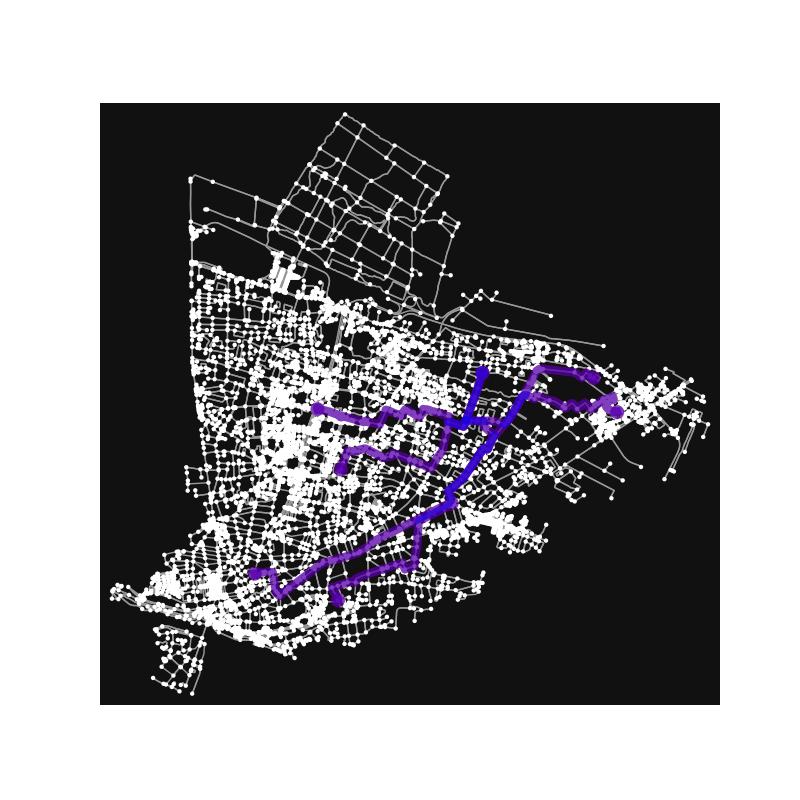

In [15]:
affiche_avant_après(tous_les_chemins, g, 10)

In [11]:
matplotlib.pyplot.close("all")

(Je ne vois pas comment zoomer sur l'image dans cette interface... À chercher.)

La fonction finale : prend deux adresses et affiche l'itinéraire. L'argument p_détour est la proportion de détour acceptée. 0=pas de détour.

In [ ]:
def itinéraire(départ, arrivée, p_détour, g):
    """ Fonction finale. Affiche l'itinéraire, en utilisant le graphe déjà entrainé."""
    id_d = g.nœud_centre_rue(départ)
    id_a = g.nœud_centre_rue(arrivée)
    c = g.chemin(id_d, id_a, p_détour)
    g.affiche_chemin(c)

Utilisation de la fonction finale. Remplacez les adresses par ce que vous voulez (à Pau pour l'instant...). Gardez en tête que les adresses sont retrouvées depuis openstreetmap, qui n'a pas très à l'ausi avec les fautes de frappe.

In [ ]:
itinéraire("rue Roger Salengro", "rue Jean Moulin",.5, g)


Si on veut bien voir l'apport de l'IA, la fonction suivante afiche d'abord le chemin le plus court classique, puis lance l'apprentissage, et affiche le nouveau chemin en bleu.

In [ ]:
def test(départ, arrivée, p_détour):
    """ départ et arrivée : des adresses (type str)"""
    g.réinitialise_cyclabilité() # On efface l'apprentissage.
    id_d = g.nœud_centre_rue(départ)
    id_a = g.nœud_centre_rue(arrivée)

    chemin_avant = g.chemin(id_d, id_a, p_détour)


    apprentissage.n_lectures(10, g, tous_les_chemins, bavard=1)

    chemin_après = g.chemin(id_d, id_a, p_détour)

    g.affiche_chemins([chemin_avant, chemin_après], {"route_colors":["r","b"]})

In [ ]:
test("rue Roger Salengro", "rue Jean Moulin",.5)

Sur cet exemple on voit que l'IA a appris qu'il valait mieux passer par le chemin des écoles et la rue Mozart.